# Analisando o bot

Este jupyter-notebook vai auxiliar na análise de um RASA bot.

## Instalação

### Configurando jupyter

In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Instalação do Rasa


In [2]:
import sys
python = sys.executable

# In your environment run:
#!{python} -m pip install -U rasa_core==0.9.0a7 rasa_nlu[spacy];
!{python} -m pip install -U rasa_core==0.10.3 rasa_nlu[spacy]==0.13.0;

# as well as install a language model:
!{python} -m spacy download pt;

Requirement already up-to-date: rasa_core==0.10.3 in /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages (0.10.3)
Requirement already up-to-date: rasa_nlu[spacy]==0.13.0 in /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages (0.13.0)



    Linking successful
    /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pt_core_news_sm
    -->
    /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages/spacy/data/pt

    You can now load the model via spacy.load('pt')



Verificando versões:

In [3]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("pt")("Olá Mundo!"))

rasa_nlu: 0.13.0 rasa_core: 0.10.3
Loading spaCy language model...
Olá Mundo!


### Ferramentas adicionais

Atualize a instalação de acordo com seu sistema operacional

In [4]:
#!apt-get -qq install -y graphviz libgraphviz-dev pkg-config;
#!brew install graphviz;

In [5]:
!{python} -m pip install pygraphviz;

### NLU Pipeline

Criando um pipeline de nlu para o bot.

`Caso queira testar diferentes algoritmos/modelos dentro do RASA nlu, mude a celula seguinte.`

In [6]:
config = """
language: "pt"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_spacy"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


## Adicionando nlu (natural language understanding)

Nesta parte o bot vai aprender a entender a linguagem

### Treinando o modelo do Rasa NLU

In [7]:
import os

from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config


intents_directory = 'intents/'

intents = {}

for intent_file in os.listdir(intents_directory):
    intent_file_path = os.path.join(intents_directory, intent_file)

    intents[intent_file] = {}

    intent_list = []
    intent_name = None

    with open(intent_file_path) as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip()

            if line.startswith('##'):
                if intent_name is not None:
                    intents[intent_file][intent_name] = intent_list
                intent_name = line.replace('## intent:', '') 
                intent_list = []

            elif line.startswith('- '):
                intent_list.append(line.replace('- ', ''))


# loading the nlu training samples
training_data = load_data(intents_directory)

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of intents/geral.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 220 (7 distinct intents)
	- Found intents: 'extra', 'o_que_eh', 'afirmar_curiosidades', 'cumprimentar', 'afirmar_projeto', 'negar', 'afirmar'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INFO:rasa_nlu.training_data.loading:Training data format of intents/curiosidades.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 153 (8 distinct intents)
	- Found intents: 'curiosidades_receber_incetivo_de_parentes', 'curiosidades_lei_rouanet_elegibilidade', 'curiosidades_lei_rouanet_arrecadamento', 'curiosidades_elegibilidade_de_empresa_para_beneficios', 'curiosidades_lei_rouanet_denuncia', 'curiosidades_quantidade_projetos', 'curiosidades_beneficios_incentivo_projetos_culturais', 'curiosidades_deducao_imposto_de_renda_incentivador'
	- entity examples: 0 (0 distinct entitie

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.8s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into '/home/arthur/Documents/lappis/bot/rasa-demo-pydata18/tais/models/nlu/default/current'


### Avaliação do modelo de NLU treinado

`Caso queira testar mensagens específicas mande a mensagem na célula seguinte`

In [8]:
pprint(interpreter.parse("sim"))

{
  "intent": {
    "name": "afirmar",
    "confidence": 0.5896280185776268
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "afirmar",
      "confidence": 0.5896280185776268
    },
    {
      "name": "extra",
      "confidence": 0.18368679427401943
    },
    {
      "name": "negar",
      "confidence": 0.10545517316061688
    },
    {
      "name": "cumprimentar",
      "confidence": 0.10072375394195486
    },
    {
      "name": "afirmar_curiosidades",
      "confidence": 0.004177625212902297
    },
    {
      "name": "curiosidades_lei_rouanet_elegibilidade",
      "confidence": 0.003200388213807229
    },
    {
      "name": "curiosidades_lei_rouanet_denuncia",
      "confidence": 0.0026543963668451166
    },
    {
      "name": "afirmar_projeto",
      "confidence": 0.001953351254312715
    },
    {
      "name": "o_que_eh",
      "confidence": 0.0017279692767743827
    },
    {
      "name": "curiosidades_lei_rouanet_arrecadamento",
      "confidence": 0.0014206

### Avaliação de correlação das intents

In [14]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation(data_path='intents/geral.md', model_path=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-pt'.
INFO:rasa_nlu.training_data.loading:Training data format of intents/geral.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 220 (7 distinct intents)
	- Found intents: 'extra', 'o_que_eh', 'afirmar_curiosidades', 'cumprimentar', 'afirmar_projeto', 'negar', 'afirmar'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 220 examples that have a defined intent out of 220 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9717045454545454
INFO:rasa_nlu.evaluate:Precision: 0.9753198339405236
INFO:rasa_nlu.evaluate:Accuracy:  0.9727272727272728
INFO:rasa_nlu.evaluate:Classification report: 
                      precision    recall  f1-score   support

             afirmar       0.89      1.00      0.94        33
afirmar_curiosidades       1.00      

TypeError: expected str, bytes or os.PathLike object, not NoneType

# RASA core

`Adicionando stories`

### Definindo Contexto (domain)

### Visualização do fluxo de conversa

In [11]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent('domain.yml')
agent.visualize("stories.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

INFO:apscheduler.scheduler:Scheduler started
/home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pykwalify/core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)
ERROR:pykwalify.core:validation.invalid
ERROR:pykwalify.core: --- All found errors ---
ERROR:pykwalify.core:['Value \'{\'utter_cumprimentar\': [{\'text\': \'Olá, meu  nome é Taís, sou assistente virtual do MinC\\n\\n Estou aqui para te ajudar a sanar dúvidas sobre a lei Rouanet\\n\'}, {\'text\': \'Oi, eu sou a Taís, assistente virtual do MinC\\n\\n Estou aqui para te ajudar a tirar dúvidas sobre a lei Rouanet\\n\'}, {\'text\': \'Oi, sou assistente virtual

TypeError: expected str, bytes or os.PathLike object, not method

### Treinando o modelo de diálogo

`Para verificar possíveis melhorias no comportamento do bot mude a célula a seguir`

**importante** após identifcar melhorias atualize o arquivo de treinho do bot `train.py`

In [22]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.6)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=400
)

agent.persist('models/dialogue')

Using TensorFlow backend.
ERROR:pykwalify.core:validation.invalid
ERROR:pykwalify.core: --- All found errors ---
ERROR:pykwalify.core:['Value \'{\'utter_cumprimentar\': [{\'text\': \'Olá, meu  nome é Taís, sou assistente virtual do MinC\\n\\n Estou aqui para te ajudar a sanar dúvidas sobre a lei Rouanet\\n\'}, {\'text\': \'Oi, eu sou a Taís, assistente virtual do MinC\\n\\n Estou aqui para te ajudar a tirar dúvidas sobre a lei Rouanet\\n\'}, {\'text\': \'Oi, sou assistente virtual do MinC, me chamo Taís\\n\\n Estou aqui para te ajudar a esclarecer dúvidas sobre a lei Rouanet\\n\'}], \'utter_despedir\': [{\'text\': \'Foi um prazer te ajudar!\\n\\nSempre que tiver alguma dúvida, volte aqui!\\n\\nAté logo!\\n\'}, {\'text\': \'Foi um prazer te ajudar!\\n\\nSempre que precisar, volte aqui!\\n\\nAté a próxima!\\n\'}, {\'text\': \'Foi um prazer te ajudar!\\n\\nQuando surgir alguma dúvida, volte aqui!\\n\\nAté mais!\\n\'}], \'utter_fase_de_testes\': [{\'text\': \'Ainda não consigo falar sobre 

ValueError: Failed to validate your domain yaml '/home/arthur/Documents/lappis/bot/rasa-demo-pydata18/tais/domain.yml'. Make sure the file is correct, to do sotake a look at the errors logged during validation previous to this exception. 

### Inicializando bot completo (core+nlu)

In [44]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


### Testando conversação

In [23]:
print("Converse com o bot, diga 'stop' para encerrar teste.")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])


Converse com o bot, diga 'stop' para encerrar teste.
sim


NameError: name 'agent' is not defined

### Avaliação do modelo de diálogo (`stories`)

Processed Story Blocks: 100%|██████████| 6/6 [00:00<00:00, 1871.90it/s]
INFO:rasa_core.evaluate:Evaluating 6 stories
Progress:
100%|██████████| 6/6 [00:00<00:00, 27.54it/s]
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  1.0
INFO:rasa_nlu.evaluate:Classification report: 
                       precision    recall  f1-score   support

        action_listen       1.00      1.00      1.00        13
action_retrieve_image       1.00      1.00      1.00         2
       utter_cheer_up       1.00      1.00      1.00         2
  utter_did_that_help       1.00      1.00      1.00         2
        utter_goodbye       1.00      1.00      1.00         3
          utter_greet       1.00      1.00      1.00         3
          utter_happy       1.00      1.00      1.00         4
        utter_unclear       1.00      1.00      1.00         1

          avg / total       1.00      1.00      1.00        30

INFO:rasa_nlu.evaluate:Confusion 

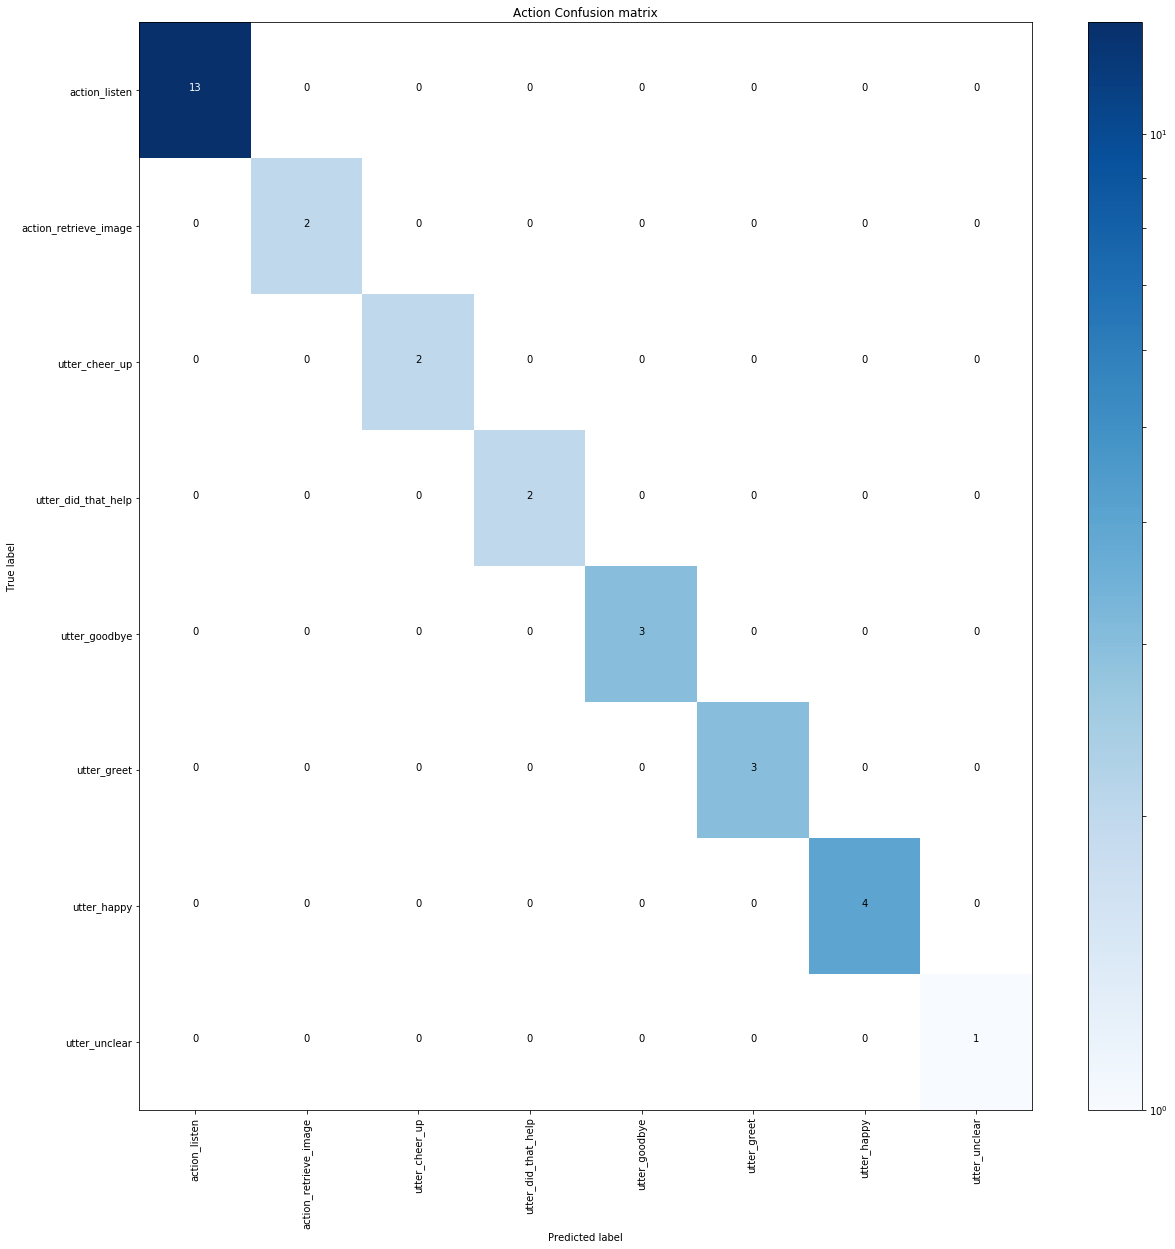

In [46]:
from rasa_core.evaluate import run_story_evaluation

run_story_evaluation("stories.md", "models/dialogue", 
                     nlu_model_path=None, 
                     max_stories=None, 
                     out_file_plot="story_eval.pdf")